# Mental Task Classification with Neural Networks

---

__Elliott Forney - 2021__

In [1]:
import copy, pickle
import collections, collections.abc
from glob import glob
import json, munch

import numpy as np
import scipy as sp
import scipy.signal as _
import torch as th

import sklearn
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8.5]

In [2]:
full_chan_names = ('F1', 'F2', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'MARKER')

#full_chan_names = (
#    'Fp1', 'AF7', 'AF3', 'F1',  'F3',  'F5',  'F7',  'FT7',                                  
#    'FC5', 'FC3', 'FC1', 'C1',  'C3',  'C5',  'T7',  'TP7',                                  
#    'CP5', 'CP3', 'CP1', 'P1',  'P3',  'P5',  'P7',  'P9',                                   
#    'PO7', 'PO3', 'O1',  'Iz',  'Oz',  'POz', 'Pz',  'CPz',                                  
#    'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz',  'F2',  'F4',                                   
#    'F6',  'F8',  'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',                                   
#    'C2',  'C4',  'C6',  'T8',  'TP8', 'CP6', 'CP4', 'CP2',                                  
#    'P2',  'P4',  'P6',  'P8',  'P10', 'PO8', 'PO4', 'O2',                                   
#    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8',
#    'MARKER'
#)

In [3]:
select_chan_names = ('F1', 'F2', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2')

#select_chan_names = (
#    'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2',                 
#    'Fz', 'O1', 'O2', 'P3', 'P4', 'P7', 'P8', 'Pz', 'T7', 'T8'
#)
#select_chan_names = (
#    'Cz', 'Fz', 'Oz', 'P3', 'P4', 'P7', 'P8', 'Pz',
#)

In [4]:
class MTDataset(th.utils.data.Dataset):
    def __init__(self, subject, partition='train', full_samp_rate=256.0,
                 full_chan_names=full_chan_names, select_chan_names=select_chan_names,
                 low_freq=2.0, high_freq=100.0, downsample_factor=1, standardize=None):
        # load the data from pickled matrix
        data = self._load_gtec_data(subject, partition)
        assert data.ndim == 2
        assert data.shape[1] == len(full_chan_names)
        
        # segment markers are stored in last channel
        # downsampled to match final date sampling rate
        markers = data[::downsample_factor, -1].copy()
        self.markers = markers
        
        # reference data to earlobes
        #data = self._reference(data)
        
        # select channels to keep
        select_chan_idxs = [full_chan_names.index(name) for name in select_chan_names]
        data = data[:, select_chan_idxs]
        self.chan_names = select_chan_names
        
        # notch filter to remove 60Hz
        data = self._notch_filter(data, full_samp_rate)
        
        # bandpass filter to specified range
        data = self._bandpass_filter(data, full_samp_rate, low_freq, high_freq)
        
        # clip signal to 100uV
        data = data.clip(-100.0, 100.0)
        
        # downsample
        data = data[::downsample_factor]
        self.samp_rate = full_samp_rate / downsample_factor
        
        # standardize so that each channel has zero mean and unit variance
        data, means, stdevs = self._standardize(data, standardize)
        self.standardize = means, stdevs

        # segment and split
        segments, labels = self._segment(data, markers, self.samp_rate)
        segments, labels = self._split(segments, labels)
        
        # validation / test split
        #split = segments.shape[0] // 2
        #if partition == 'valid':
        #    segments = segments[:split]
        #    labels = labels[:split]
        #elif partition == 'test':
        #    segments = segments[split:]
        #    labels = labels[split:]
        
        self.segments = th.as_tensor(segments, dtype=th.float32)
        self.labels = th.as_tensor(labels, dtype=th.int64)

    @staticmethod
    def _load_biosemi_data(subject, partition):
        # first session for training and second for testing
        # we'll use cross validation for model selection
        if partition == 'train':
            session_name = 'train1'
        elif partition == 'test' or partition == 'valid':
            session_name = 'train2'
        else:
            raise ValueError(f'Invalid partition `{partition}`')

        # glob data filename
        filenames = glob(f'data/subject-{subject:03}/day*/s??-d2-mentaltasks-{session_name}-???.pkl')
        assert len(filenames) == 1
        filename, = filenames

        # load data from pickled matrix, rows are timesteps and cols are channels
        with open(filename, mode='rb') as fh:
            return pickle.load(fh, encoding='bytes')
        
    @staticmethod
    def _load_gtec_data(subject, partition):
        # first session for training and second for testing
        # we'll use cross validation for model selection
        if partition == 'full_train':
            trials = 1, 2, 3, 4
        elif partition == 'train':
            trials = 1, 2, 3
        elif partition == 'valid':
            trials = 4,
        elif partition == 'test':
            trials = 5,
        else:
            raise ValueError(f'Invalid partition `{partition}`')

        # glob data filename
        filenames = [f'data/subject-{subject:03}/gtec/s{subject}-mentaltasks-trial{trial}.pkl'
                     for trial in trials]

        data = []
        for filename in filenames:
            # load data from pickled matrix, rows are timesteps and cols are channels
            with open(filename, mode='rb') as fh:
                data.append(pickle.load(fh, encoding='bytes').T)
        
        return np.vstack(data)

    @staticmethod
    def _reference(data, ref_chan_names=('EXG5', 'EXG6')):
        ref_chan_idxs = [full_chan_names.index(name) for name in ref_chan_names]

        data -= data.mean(0)
        reference = data[:, ref_chan_idxs].mean(1)[:, None]
        
        data -= reference
        
        return data

    @staticmethod
    def _notch_filter(data, samp_rate, freq=60.0, quality=15.0):
        '''Apply a bidirectional Butterworth linear IIR notch filter.
        '''
        numer_coef, denom_coef = sp.signal.iirnotch(freq, quality, fs=samp_rate)
        return sp.signal.filtfilt(numer_coef, denom_coef, data, axis=0, padtype='even')
        
    @staticmethod
    def _bandpass_filter(data, samp_rate, low_freq, high_freq, order=3):
        '''Apply a bidirectional Butterworth linear IIR bandpass filter,
        using as a cascade of second order sections.
        '''  
        # compute the filter coefficients
        sos = sp.signal.iirfilter(
            order, (low_freq, high_freq), ftype='butter', btype='bandpass', fs=samp_rate, output='sos')
        return sp.signal.sosfiltfilt(sos, data, axis=0, padtype='even')

    @staticmethod
    def _standardize(data, standardize):
        means = data.mean(0) if standardize is None else standardize[0]
        data -= means

        stdevs = data.std(0) if standardize is None else standardize[1]
        data /= stdevs
        
        return data, means, stdevs
    
    @staticmethod
    def _segment(data, markers, samp_rate, width=10.0):
        diffs = np.diff(np.abs(markers))
        starts = np.where(diffs > 0.0)[0] + 1

        width_steps = int(width * samp_rate)

        segments = np.stack([data[start:start+width_steps] for start in starts])
        #labels = markers[starts].astype(np.int) - 1 # biosemi / cebl3
        labels = markers[starts].astype(np.int)
        def label_map(label):
            char = chr(label)
            if char == 'C':
                return 0
            if char == 'F':
                return 1
            if char == 'R':
                return 2
            if char == 'S':
                return 3
            raise ValueError(f'Invalid marker {char}')
            
        labels = np.array(list(map(label_map, labels)))

        return np.ascontiguousarray(segments), labels
    
    @staticmethod
    def _split(segments, labels, n=5):
        segs, labs = [], []
        origstep = segments.shape[1]
        newstep = int(origstep / n)
        for segment, label in zip(segments, labels):
            for start in range(0, origstep, newstep):
                seg = segment[start:start+newstep]
                if seg.shape[0] < newstep:
                    break
                segs.append(seg)
                labs.append(label)
        
        segments = np.stack(segs, axis=0)
        labels = np.array(labs, dtype=np.int)
        
        return segments, labels
    
    def plot_trace(self, n, scale_factor=0.75):
        if isinstance(n, int):
            segment, label = self[n]
        
        segment = segment
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        nsec = segment.shape[0] / self.samp_rate
    
        nchan = len(self.chan_names)
    
        scale = th.max(th.abs(segment))                                                                                                                                                                   
        sep = -th.arange(segment.shape[1]) * scale_factor * scale
        segment = segment + sep
        
        time = th.linspace(0, nsec, segment.shape[0])
    
        ax.plot(time, segment)
        ax.set_xlabel(r'Time ($s$)')
        ax.set_ylabel(r'Signal ($\mu V$) Across Channels')
        ax.set_yticks(sep)
        ax.set_yticklabels([c for i, c in enumerate(self.chan_names)])
        ax.autoscale(tight=True)
        
    def plot_psd(self, n):
        if isinstance(n, int):
            segment, label = self[n]
        
        freqs, powers = sp.signal.welch(segment.T, self.samp_rate)

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(freqs, powers.T);
        ax.set_xlabel('Frequency (Hz)');
        ax.set_ylabel(r'Power Density ($\mu V^2/Hz$');
        ax.set_yscale('log');

        ax.grid();
        ax.legend(self.chan_names, ncol=2);
        ax.autoscale(tight=True)
    
    def __getitem__(self, idx):
        return self.segments[idx], self.labels[idx]
    
    def __len__(self):
        return self.segments.shape[0]

In [5]:
subject_id = 11

full_train_data = MTDataset(subject_id, partition='full_train')
train_data = MTDataset(subject_id, partition='train', standardize=full_train_data.standardize)
valid_data = MTDataset(subject_id, partition='valid', standardize=full_train_data.standardize)
test_data = MTDataset(subject_id, partition='test', standardize=full_train_data.standardize)

In [6]:
len(train_data), len(valid_data), len(test_data)

(60, 20, 20)

In [7]:
segments, labels = train_data[:20]
segments.shape, labels.shape

(torch.Size([20, 512, 8]), torch.Size([20]))

In [8]:
labels

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [9]:
train_data.labels

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

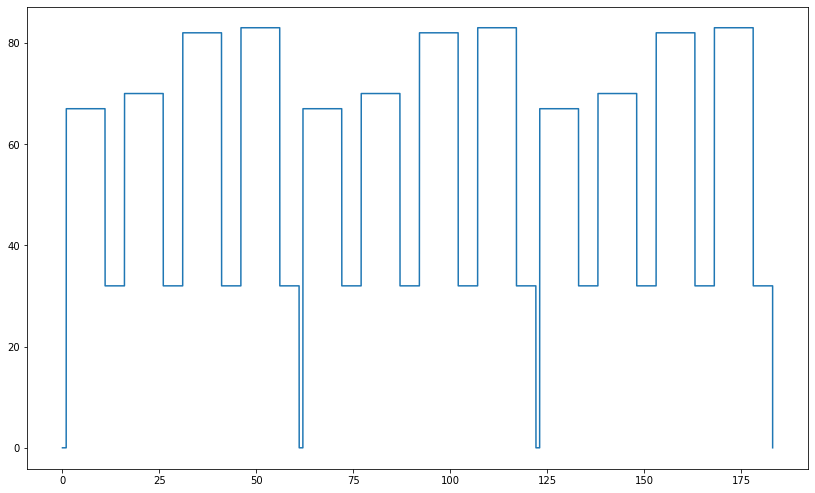

In [10]:
time = np.linspace(0, train_data.markers.shape[0]/256.0, train_data.markers.shape[0])
plt.plot(time, train_data.markers);

In [11]:
train_data.labels

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [12]:
len(train_data)

60

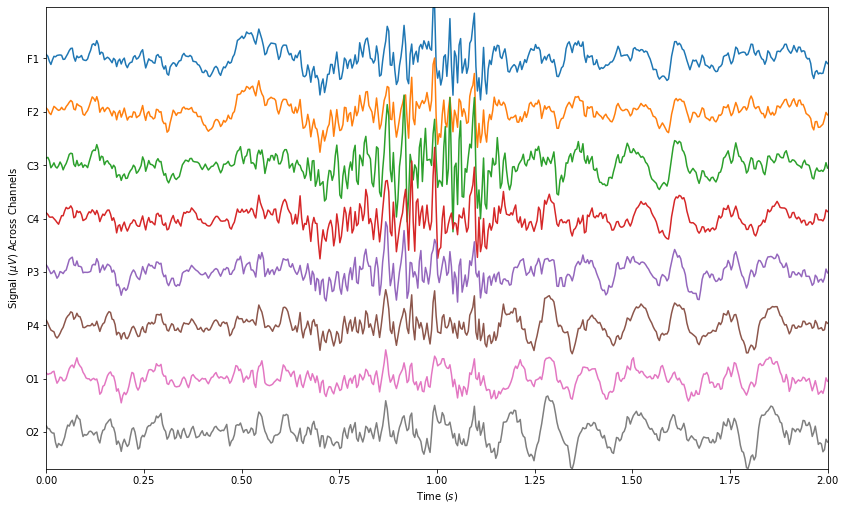

In [13]:
train_data.plot_trace(0)

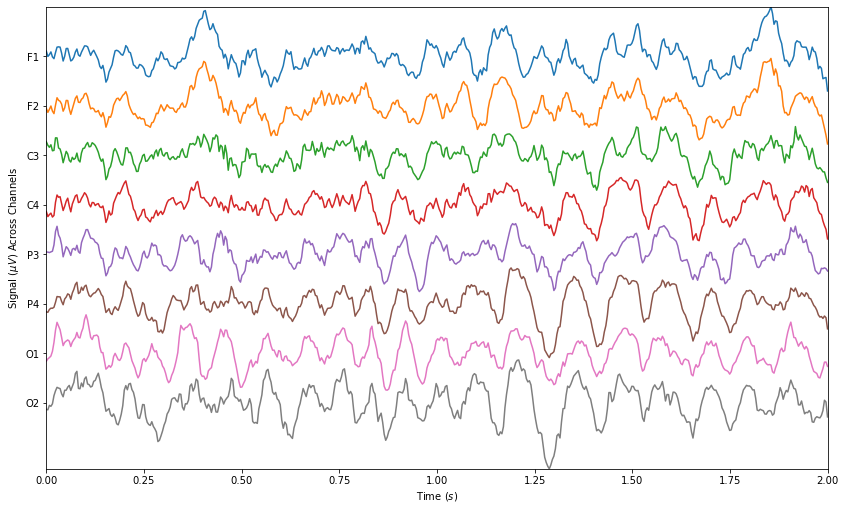

In [14]:
valid_data.plot_trace(1)

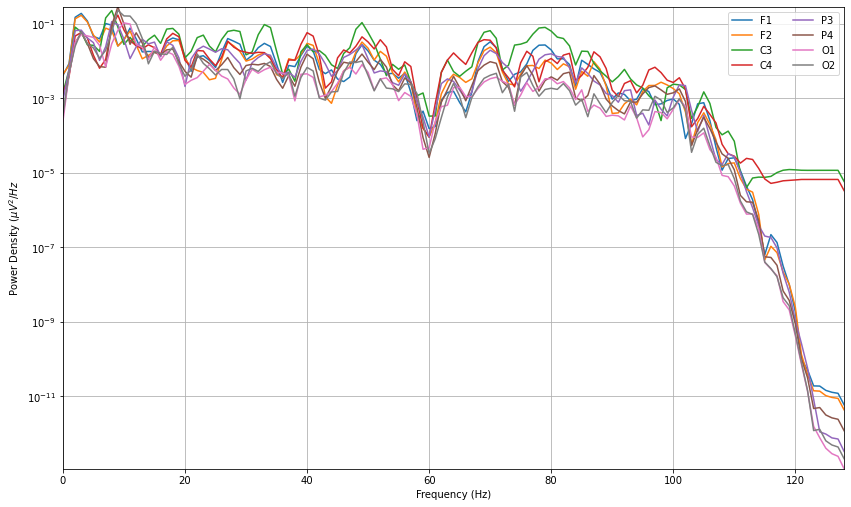

In [15]:
train_data.plot_psd(0)

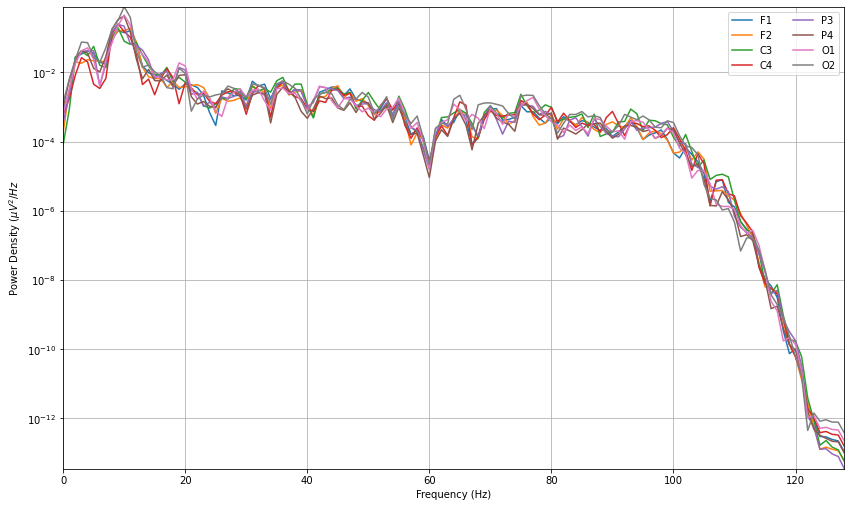

In [16]:
train_data.plot_psd(1)

## Training

In [17]:
class TrainResult(munch.Munch):
    def plot_losses(self):
        plt.plot(self.train_losses, linewidth=2, label='train')
        plt.plot(self.valid_losses, linewidth=2, label='valid')
        plt.scatter(
            (self.best_epoch,), (self.valid_losses[self.best_epoch],),
            linewidth=3, s=200, marker='x', color='red', label='best')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Mean Loss')
        plt.grid()
    
    def __repr__(self):
        return json.dumps(
            {key: value for key, value in self.items()
             if not isinstance(value, collections.abc.Iterable)},
            indent=4)

In [18]:
def train(model, full_train_data, train_data, valid_data, test_data,
          max_epochs=500, learning_rate=0.01, repeat_labels=False,
          device='cuda'):
    '''Train using resilient backpropagation (RProp).'''
    # transfer all model parameters to requested device
    model.to(device)
    
    initial_state = copy.deepcopy(model.state_dict())

    # all parameters with `requires_grad` set
    parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
    
    # cross entropy loss
    loss_func = th.nn.CrossEntropyLoss(reduction='mean')

    # RProp optimizer
    optimizer = th.optim.Rprop(lr=learning_rate, params=parameters)
    #optimizer = th.optim.Adam(lr=0.0025, params=parameters)
    #optimizer = th.optim.Adam(lr=0.001, params=parameters)

    # performance metrics
    train_losses = []
    valid_losses = []

    # best model state for early stopping
    best_train_loss = float('inf')
    best_valid_loss = float('inf')
    best_epoch = 0
    
    # data and labels for each dataset
    full_train_segments = full_train_data.segments
    full_train_labels = full_train_data.labels
    
    train_segments = train_data.segments
    train_labels = train_data.labels
    
    valid_segments = valid_data.segments
    valid_labels = valid_data.labels
    
    test_segments = test_data.segments
    test_labels = test_data.labels
    
    def get_train_closure(segments, labels, losses):       
        segments = segments.to(device)
        labels = labels.to(device)
        
        def train_step():
            model.train()
            
            # zero the gradients
            optimizer.zero_grad()
        
            # forward pass
            logits = model(segments)
            
            if repeat_labels:
                ll = labels.repeat_interleave(logits.shape[-1]).reshape(labels.shape[0], -1)
            else:
                ll = labels
            
            loss = loss_func(logits, ll)
        
            # save float of loss for accounting
            losses.append(loss.item())

            # backward pass
            loss.backward()
            
            model.eval()

            return loss
        return train_step
    
    def get_valid_closure(segments, labels, losses):
        segments = segments.to(device)
        labels = labels.to(device)
        
        def valid_step():
            with th.no_grad():
                logits = model(segments)
                
                if repeat_labels:
                    ll = labels.repeat_interleave(logits.shape[-1]).reshape(labels.shape[0], -1)
                else:
                    ll = labels
                
                loss = loss_func(logits, ll)
            losses.append(loss.item())
            
            return loss
        return valid_step
    
    train_closure = get_train_closure(train_segments, train_labels, train_losses)
    valid_closure = get_valid_closure(valid_segments, valid_labels, valid_losses)

    # for each training epoch
    for epoch in range(max_epochs):
        # training update
        optimizer.step(train_closure)
        
        # validation update
        valid_closure()

        if valid_losses[-1] < best_valid_loss:
            best_train_loss = train_losses[-1]
            best_valid_loss = valid_losses[-1]
            best_epoch = epoch

        if epoch % 10 == 0:
            print('epoch:', epoch)
            print('best epoch:', best_epoch)
            print('train loss:', train_losses[-1])
            print('valid loss:', valid_losses[-1])
            print('=======')

    model.load_state_dict(initial_state)

    full_train_losses = []
    train_closure = get_train_closure(full_train_segments, full_train_labels, full_train_losses)
    
    for epoch in range(best_epoch):
        optimizer.step(train_closure)
        
        if epoch % 100 == 0:
            print('epoch:', epoch)
            print('full train loss:', full_train_losses[-1])
            print('=======')

    model.cpu()    
        
    full_train_preds = model.labels(full_train_segments)
    train_accuracy = metrics.accuracy_score(full_train_labels, full_train_preds)
    
    test_preds = model.labels(test_segments)
    test_accuracy = metrics.accuracy_score(test_labels, test_preds)

    return TrainResult({
        'model_parameters': sum(p.nelement() for p in model.parameters()),
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'full_train_losses': full_train_losses,
        'best_train_loss': best_train_loss,
        'best_valid_loss': best_valid_loss,
        'best_epoch': best_epoch,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
    })

## Seq2Label

In [19]:
class Seq2Label(th.nn.Module):
    def __init__(self, nchan, nrecurrent, ncls):
        super().__init__()
        
        self.nchan = nchan
        self.nrecurrent = nrecurrent
        self.ncls = ncls
        
        self.rnn = th.nn.RNN(self.nchan, self.nrecurrent, batch_first=True)
        self.visible = th.nn.Linear(self.nrecurrent, self.ncls)
        
    def forward(self, segments):
        assert segments.ndim == 3
        batch_size = segments.shape[0]

        _rnn_out, final_state = self.rnn(segments)
        assert final_state.shape == (1, batch_size, self.nrecurrent)
        
        visible_out = self.visible(final_state.squeeze(0))
        assert visible_out.shape == (batch_size, self.ncls)
        
        return visible_out
    
    @th.no_grad()
    def labels(self, segments):
        return th.argmax(self(segments), dim=1)
    
    @th.no_grad()
    def probs(self, segments):
        return th.nn.functional.softmax(self(segments), dim=1)

In [20]:
seq2label = Seq2Label(
    nchan=len(train_data.chan_names),
    nrecurrent=12,
    ncls=4)

In [21]:
train_result = train(seq2label, full_train_data, train_data, valid_data, test_data)

epoch: 0
best epoch: 0
train loss: 1.3905227184295654
valid loss: 1.441110610961914
epoch: 10
best epoch: 2
train loss: 1.0655288696289062
valid loss: 1.6778815984725952
epoch: 20
best epoch: 2
train loss: 0.6567162275314331
valid loss: 2.5718700885772705
epoch: 30
best epoch: 2
train loss: 0.343327134847641
valid loss: 4.081730365753174
epoch: 40
best epoch: 2
train loss: 0.1564132571220398
valid loss: 5.253732204437256
epoch: 50
best epoch: 2
train loss: 0.08839546144008636
valid loss: 6.703488349914551
epoch: 60
best epoch: 2
train loss: 0.04105651006102562
valid loss: 8.10135269165039
epoch: 70
best epoch: 2
train loss: 0.014455955475568771
valid loss: 9.869382858276367
epoch: 80
best epoch: 2
train loss: 0.005072855856269598
valid loss: 11.604512214660645
epoch: 90
best epoch: 2
train loss: 0.0010839087190106511
valid loss: 14.400041580200195
epoch: 100
best epoch: 2
train loss: 0.0002794366155285388
valid loss: 16.633642196655273
epoch: 110
best epoch: 2
train loss: 7.94174920883

In [22]:
train_result

{
    "model_parameters": 316,
    "best_train_loss": 1.3367787599563599,
    "best_valid_loss": 1.4300296306610107,
    "best_epoch": 2,
    "train_accuracy": 0.3,
    "test_accuracy": 0.3
}

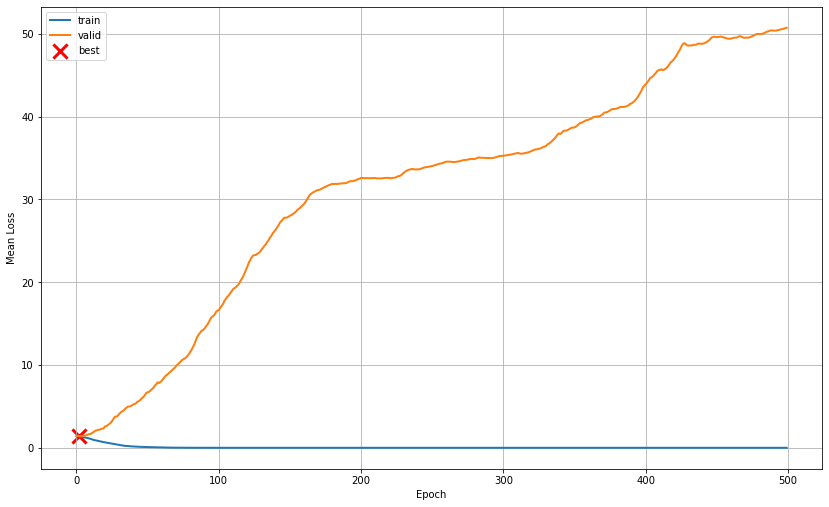

In [23]:
train_result.plot_losses()

## Fully Convolutional Net with Global Max Pool

In [24]:
class MaxCNN(th.nn.Module):
    def __init__(self, nchan, conv_specs, ncls, activation=th.nn.Tanh):
        super().__init__()
        
        self.nchan = nchan
        self.conv_specs = conv_specs
        self.ncls = ncls
        
        convs = []
        layer_in, layer_out = None, nchan
        for nfilt, kernel_size, pool_size in self.conv_specs:
            layer_in, layer_out = layer_out, nfilt
            convs.extend([
                th.nn.Conv1d(
                    layer_in, layer_out,
                    kernel_size=kernel_size),
                th.nn.AvgPool1d(pool_size),
                activation(),
            ])
        self.conv = th.nn.Sequential(*convs)

        self.visible = th.nn.Linear(layer_out, self.ncls)
        
    def forward(self, segments):
        assert segments.ndim == 3
        batch_size = segments.shape[0]

        conv_out = self.conv(segments.permute(0, 2, 1))
        assert conv_out.ndim == 3
        assert conv_out.shape[0] == batch_size
        assert conv_out.shape[1] == self.conv_specs[-1][0]
        
        #mx, _mx_idxs = th.max(conv_out, dim=2)
        #assert mx.shape == (batch_size, conv_out.shape[1])
        mx = conv_out.mean(dim=2)
        
        visible_out = self.visible(mx)
        assert visible_out.shape == (batch_size, self.ncls)
        
        return visible_out
    
    @th.no_grad()
    def labels(self, segments):
        return th.argmax(self(segments), dim=1)
    
    @th.no_grad()
    def probs(self, segments):
        return th.nn.functional.softmax(self(segments), dim=1)

In [25]:
max_cnn = MaxCNN(
    nchan=len(train_data.chan_names),
    conv_specs=(
        #(16, 3, 1),
        #(16, 3, 2),
        #(16, 3, 1),
        (48, 7, 1),
    ),
    ncls=4)

In [26]:
train_result = train(max_cnn, full_train_data, train_data, valid_data, test_data, max_epochs=1200)

epoch: 0
best epoch: 0
train loss: 1.3893342018127441
valid loss: 1.385926365852356
epoch: 10
best epoch: 10
train loss: 1.2611372470855713
valid loss: 1.3619940280914307
epoch: 20
best epoch: 10
train loss: 0.6107509136199951
valid loss: 1.625648856163025
epoch: 30
best epoch: 10
train loss: 0.021960468962788582
valid loss: 3.7858917713165283
epoch: 40
best epoch: 10
train loss: 2.7815497460892402e-08
valid loss: 11.352144241333008
epoch: 50
best epoch: 10
train loss: 0.0
valid loss: 24.35870933532715
epoch: 60
best epoch: 10
train loss: 1.192092558000013e-08
valid loss: 44.68379211425781
epoch: 70
best epoch: 10
train loss: 0.0
valid loss: 76.84111785888672
epoch: 80
best epoch: 10
train loss: 0.017485182732343674
valid loss: 93.59907531738281
epoch: 90
best epoch: 10
train loss: 0.0
valid loss: 109.0027847290039
epoch: 100
best epoch: 10
train loss: 0.0
valid loss: 133.41197204589844
epoch: 110
best epoch: 10
train loss: 1.9429980966378935e-06
valid loss: 140.41287231445312
epoch: 1

epoch: 1000
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1010
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1020
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1030
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1040
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1050
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1060
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1070
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1080
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1090
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1100
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1110
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1120
best epoch: 10
train loss: 0.0
valid loss: 482.6966857910156
epoch: 1130
best epoch: 10
train loss: 0.0
valid lo

In [27]:
train_result

{
    "model_parameters": 2932,
    "best_train_loss": 1.2611372470855713,
    "best_valid_loss": 1.3619940280914307,
    "best_epoch": 10,
    "train_accuracy": 0.275,
    "test_accuracy": 0.25
}

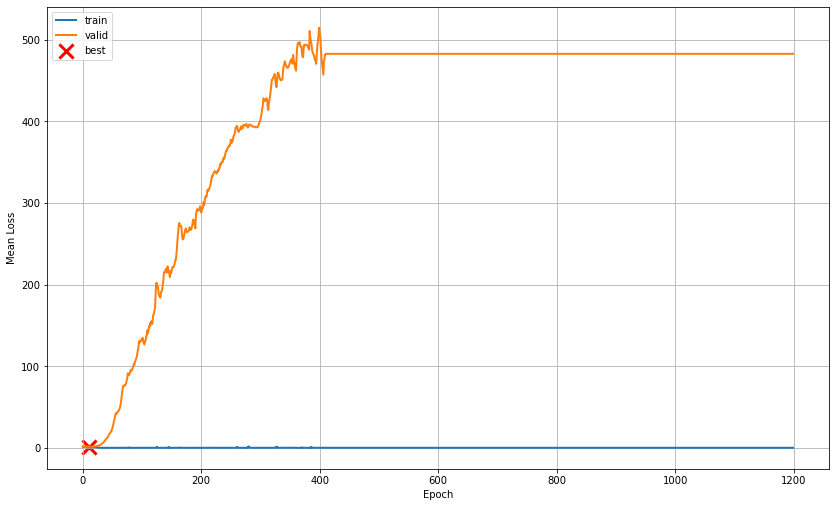

In [28]:
train_result.plot_losses()

In [29]:
train_data.labels

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [30]:
valid_data.segments.min(), valid_data.segments.max()

(tensor(-5.2796), tensor(4.7303))

In [31]:
valid_data.segments.mean(1).min(), valid_data.segments.mean(1).max()

(tensor(-0.0577), tensor(0.0552))

In [32]:
valid_data.segments.std(1).min(), valid_data.segments.std(1).max()

(tensor(0.5464), tensor(1.5911))

## CNN-LA

In [33]:
class CNNLA(th.nn.Module):
    def __init__(self, nchan, conv_specs, ncls, activation=th.nn.ReLU):
        super().__init__()
        
        self.nchan = nchan
        self.conv_specs = conv_specs
        self.ncls = ncls
        
        convs = []
        layer_in, layer_out = None, nchan
        for nfilt, kernel_size, pool_size in self.conv_specs:
            layer_in, layer_out = layer_out, nfilt
            convs.extend([
                th.nn.Conv1d(
                    layer_in, layer_out,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2),
                th.nn.AvgPool1d(pool_size),
                activation(),
            ])
        self.convs = th.nn.Sequential(*convs)

        self.visible = th.nn.Conv1d(layer_out, self.ncls, kernel_size=1)
        
    def forward(self, segments):
        assert segments.ndim == 3
        batch_size = segments.shape[0]
        seq_len = segments.shape[1]
        nchan = segments.shape[2]

        conv_out = self.convs(segments.permute(0, 2, 1))
        assert conv_out.ndim == 3
        assert conv_out.shape[0] == batch_size
        assert conv_out.shape[1] == self.conv_specs[-1][0] # nfilt
        #assert conv_out.shape[2] == seq_len

        visible_out = self.visible(conv_out)
        #assert visible_out.shape == (batch_size, self.ncls, seq_len)
        assert visible_out.ndim == 3
        assert visible_out.shape[0] == batch_size
        assert visible_out.shape[1] == self.ncls
        
        return visible_out
    
    @th.no_grad()
    def labels(self, segments):
        return th.argmax(self(segments).sum(-1), dim=1)
    
    @th.no_grad()
    def probs(self, segments):
        return th.nn.functional.softmax(self(segments), dim=1)

In [44]:
cnn_la = CNNLA(
    nchan=len(train_data.chan_names),
    conv_specs=(
        (16, 3, 1),
        (16, 3, 2),
        (16, 3, 1),
        #(48, 7, 1),
        #(16, 5, 1),
        #(16, 5, 2),
        #(20, 3, 1),
        #(20, 3, 1),
    ),
    ncls=4)

cnn_la

CNNLA(
  (convs): Sequential(
    (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
    (2): ReLU()
    (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (5): ReLU()
    (6): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): AvgPool1d(kernel_size=(1,), stride=(1,), padding=(0,))
    (8): ReLU()
  )
  (visible): Conv1d(16, 4, kernel_size=(1,), stride=(1,))
)

In [45]:
train_result = train(
    cnn_la, full_train_data, train_data, valid_data, test_data,
    repeat_labels=True, max_epochs=5000)

epoch: 0
best epoch: 0
train loss: 1.3941622972488403
valid loss: 1.3878505229949951
epoch: 10
best epoch: 3
train loss: 1.3487955331802368
valid loss: 1.3962953090667725
epoch: 20
best epoch: 3
train loss: 1.3156468868255615
valid loss: 1.410386323928833
epoch: 30
best epoch: 3
train loss: 1.292317271232605
valid loss: 1.4188206195831299
epoch: 40
best epoch: 3
train loss: 1.2780125141143799
valid loss: 1.4285595417022705
epoch: 50
best epoch: 3
train loss: 1.2648354768753052
valid loss: 1.4349844455718994
epoch: 60
best epoch: 3
train loss: 1.2540980577468872
valid loss: 1.4370204210281372
epoch: 70
best epoch: 3
train loss: 1.2439604997634888
valid loss: 1.4357588291168213
epoch: 80
best epoch: 3
train loss: 1.2330477237701416
valid loss: 1.4391329288482666
epoch: 90
best epoch: 3
train loss: 1.2234559059143066
valid loss: 1.4361226558685303
epoch: 100
best epoch: 3
train loss: 1.21376633644104
valid loss: 1.4298547506332397
epoch: 110
best epoch: 3
train loss: 1.2046107053756714
va

epoch: 890
best epoch: 246
train loss: 1.0263718366622925
valid loss: 1.4567254781723022
epoch: 900
best epoch: 246
train loss: 1.0260008573532104
valid loss: 1.458547830581665
epoch: 910
best epoch: 246
train loss: 1.0256781578063965
valid loss: 1.4600473642349243
epoch: 920
best epoch: 246
train loss: 1.0253483057022095
valid loss: 1.4595277309417725
epoch: 930
best epoch: 246
train loss: 1.0250719785690308
valid loss: 1.460235357284546
epoch: 940
best epoch: 246
train loss: 1.0247358083724976
valid loss: 1.4609776735305786
epoch: 950
best epoch: 246
train loss: 1.0244070291519165
valid loss: 1.4613412618637085
epoch: 960
best epoch: 246
train loss: 1.0241039991378784
valid loss: 1.4609301090240479
epoch: 970
best epoch: 246
train loss: 1.023789644241333
valid loss: 1.4607833623886108
epoch: 980
best epoch: 246
train loss: 1.0234967470169067
valid loss: 1.462226152420044
epoch: 990
best epoch: 246
train loss: 1.0232601165771484
valid loss: 1.4623640775680542
epoch: 1000
best epoch: 2

epoch: 1750
best epoch: 246
train loss: 1.010184645652771
valid loss: 1.491803765296936
epoch: 1760
best epoch: 246
train loss: 1.0100780725479126
valid loss: 1.492300271987915
epoch: 1770
best epoch: 246
train loss: 1.0099703073501587
valid loss: 1.4929306507110596
epoch: 1780
best epoch: 246
train loss: 1.0098425149917603
valid loss: 1.493219017982483
epoch: 1790
best epoch: 246
train loss: 1.0097166299819946
valid loss: 1.4935004711151123
epoch: 1800
best epoch: 246
train loss: 1.0096007585525513
valid loss: 1.4934494495391846
epoch: 1810
best epoch: 246
train loss: 1.0094988346099854
valid loss: 1.4935294389724731
epoch: 1820
best epoch: 246
train loss: 1.0093899965286255
valid loss: 1.4935810565948486
epoch: 1830
best epoch: 246
train loss: 1.0093265771865845
valid loss: 1.4938591718673706
epoch: 1840
best epoch: 246
train loss: 1.0092567205429077
valid loss: 1.4938347339630127
epoch: 1850
best epoch: 246
train loss: 1.0091757774353027
valid loss: 1.49412202835083
epoch: 1860
best

epoch: 2630
best epoch: 246
train loss: 1.0051332712173462
valid loss: 1.5032652616500854
epoch: 2640
best epoch: 246
train loss: 1.005077600479126
valid loss: 1.503219485282898
epoch: 2650
best epoch: 246
train loss: 1.0050182342529297
valid loss: 1.5034205913543701
epoch: 2660
best epoch: 246
train loss: 1.004963755607605
valid loss: 1.5034900903701782
epoch: 2670
best epoch: 246
train loss: 1.0049107074737549
valid loss: 1.5036749839782715
epoch: 2680
best epoch: 246
train loss: 1.0048545598983765
valid loss: 1.5042296648025513
epoch: 2690
best epoch: 246
train loss: 1.0047866106033325
valid loss: 1.504582166671753
epoch: 2700
best epoch: 246
train loss: 1.0047237873077393
valid loss: 1.5045175552368164
epoch: 2710
best epoch: 246
train loss: 1.004669189453125
valid loss: 1.5044372081756592
epoch: 2720
best epoch: 246
train loss: 1.0046178102493286
valid loss: 1.5044643878936768
epoch: 2730
best epoch: 246
train loss: 1.0045788288116455
valid loss: 1.5042766332626343
epoch: 2740
bes

epoch: 3500
best epoch: 246
train loss: 1.0016639232635498
valid loss: 1.509418249130249
epoch: 3510
best epoch: 246
train loss: 1.0016405582427979
valid loss: 1.5097682476043701
epoch: 3520
best epoch: 246
train loss: 1.0016177892684937
valid loss: 1.5097475051879883
epoch: 3530
best epoch: 246
train loss: 1.0015946626663208
valid loss: 1.5098068714141846
epoch: 3540
best epoch: 246
train loss: 1.0015701055526733
valid loss: 1.5098308324813843
epoch: 3550
best epoch: 246
train loss: 1.0015462636947632
valid loss: 1.5098260641098022
epoch: 3560
best epoch: 246
train loss: 1.0015205144882202
valid loss: 1.5100475549697876
epoch: 3570
best epoch: 246
train loss: 1.0014854669570923
valid loss: 1.5101230144500732
epoch: 3580
best epoch: 246
train loss: 1.0014482736587524
valid loss: 1.5098832845687866
epoch: 3590
best epoch: 246
train loss: 1.001413106918335
valid loss: 1.5096042156219482
epoch: 3600
best epoch: 246
train loss: 1.0013736486434937
valid loss: 1.5098583698272705
epoch: 3610


epoch: 4340
best epoch: 246
train loss: 0.999413251876831
valid loss: 1.5132133960723877
epoch: 4350
best epoch: 246
train loss: 0.9993970394134521
valid loss: 1.513279676437378
epoch: 4360
best epoch: 246
train loss: 0.9993763566017151
valid loss: 1.513323426246643
epoch: 4370
best epoch: 246
train loss: 0.9993594288825989
valid loss: 1.5134775638580322
epoch: 4380
best epoch: 246
train loss: 0.9993423223495483
valid loss: 1.5133025646209717
epoch: 4390
best epoch: 246
train loss: 0.9993217587471008
valid loss: 1.5132458209991455
epoch: 4400
best epoch: 246
train loss: 0.9993032217025757
valid loss: 1.5133006572723389
epoch: 4410
best epoch: 246
train loss: 0.999284565448761
valid loss: 1.5133388042449951
epoch: 4420
best epoch: 246
train loss: 0.9992645382881165
valid loss: 1.5132368803024292
epoch: 4430
best epoch: 246
train loss: 0.9992434978485107
valid loss: 1.513215184211731
epoch: 4440
best epoch: 246
train loss: 0.9992234706878662
valid loss: 1.5132381916046143
epoch: 4450
bes

In [46]:
train_result

{
    "model_parameters": 2036,
    "best_train_loss": 1.109197974205017,
    "best_valid_loss": 1.3781747817993164,
    "best_epoch": 246,
    "train_accuracy": 0.875,
    "test_accuracy": 0.8
}

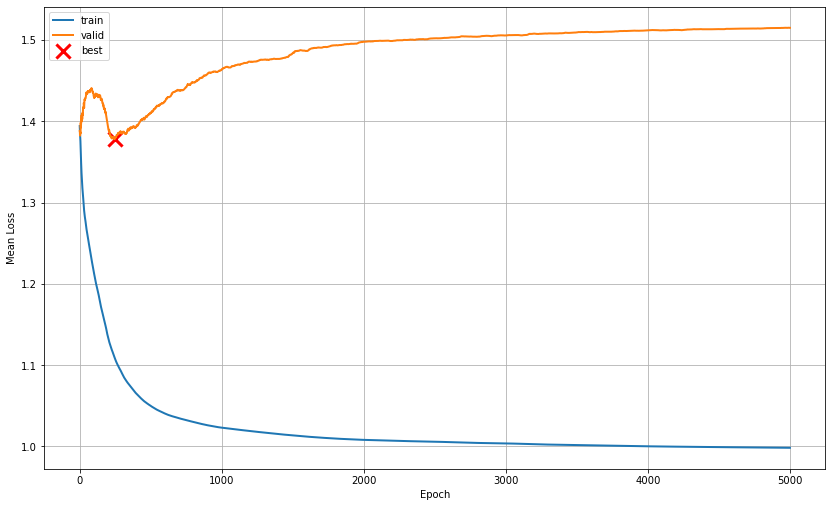

In [47]:
train_result.plot_losses()

## RNN-LA

In [48]:
class RNN(th.nn.Module):
    def __init__(self, input_size, nunits, pool_size):
        super().__init__()
        self.rec_forward = th.nn.RNN(input_size, nunits, batch_first=True)
        self.rec_backward = th.nn.RNN(nunits, nunits, batch_first=True)
        if pool_size > 1:
            self.pool = th.nn.AvgPool1d(pool_size)
        else:
            self.pool = lambda x: x
        
    def forward(self, segs):
        # todo: this is a hack with all the permute, must be a better way
        forward_out, _state = self.rec_forward(segs.permute(0, 2, 1))
        backward_out, _state = self.rec_backward(forward_out.flip(1))
        return self.pool(backward_out.permute(0, 2, 1))

In [49]:
class RNNLA(th.nn.Module):
    def __init__(self, nchan, rec_specs, ncls, activation=th.nn.Tanh):
        super().__init__()
        
        self.nchan = nchan
        self.rec_specs = rec_specs
        self.ncls = ncls
        
        recs = []
        layer_in, layer_out = None, nchan
        for nunits, pool_size in self.rec_specs:
            layer_in, layer_out = layer_out, nunits
            recs.append(
                RNN(layer_in, layer_out, pool_size))
        self.recs = th.nn.Sequential(*recs)

        self.visible = th.nn.Conv1d(layer_out, self.ncls, kernel_size=1)
        
    def forward(self, segments):
        assert segments.ndim == 3
        batch_size = segments.shape[0]
        seq_len = segments.shape[1]
        nchan = segments.shape[2]

        #rec_out = segments
        #for rec in self.recs:
        #    rec_out = rec(rec_out)
        #rec_out = rec_out.permute(0, 2, 1)
        rec_out = self.recs(segments.permute(0, 2, 1))
        assert rec_out.ndim == 3
        assert rec_out.shape[0] == batch_size
        assert rec_out.shape[1] == self.rec_specs[-1][0] # nunits
        #assert conv_out.shape[2] == seq_len

        visible_out = self.visible(rec_out)
        #assert visible_out.shape == (batch_size, self.ncls, seq_len)
        assert visible_out.ndim == 3
        assert visible_out.shape[0] == batch_size
        assert visible_out.shape[1] == self.ncls
        
        return visible_out
    
    @th.no_grad()
    def labels(self, segments):
        return th.argmax(self(segments).sum(-1), dim=1)
    
    @th.no_grad()
    def probs(self, segments):
        return th.nn.functional.softmax(self(segments), dim=1)

In [50]:
rnn_la = RNNLA(
    nchan=len(train_data.chan_names),
    rec_specs=(
        (8, 1),
        (8, 2),
        (8, 1),
    ),
    ncls=4)

rnn_la

RNNLA(
  (recs): Sequential(
    (0): RNN(
      (rec_forward): RNN(8, 8, batch_first=True)
      (rec_backward): RNN(8, 8, batch_first=True)
    )
    (1): RNN(
      (rec_forward): RNN(8, 8, batch_first=True)
      (rec_backward): RNN(8, 8, batch_first=True)
      (pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (2): RNN(
      (rec_forward): RNN(8, 8, batch_first=True)
      (rec_backward): RNN(8, 8, batch_first=True)
    )
  )
  (visible): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
)

In [51]:
train_result = train(
    rnn_la, full_train_data, train_data, valid_data, test_data, 
    repeat_labels=True, max_epochs=2000)

epoch: 0
best epoch: 0
train loss: 1.4117778539657593
valid loss: 1.398664116859436
epoch: 10
best epoch: 3
train loss: 1.3822816610336304
valid loss: 1.3920023441314697
epoch: 20
best epoch: 19
train loss: 1.2908546924591064
valid loss: 1.4615833759307861
epoch: 30
best epoch: 28
train loss: 1.2478070259094238
valid loss: 1.3201602697372437
epoch: 40
best epoch: 34
train loss: 1.1662236452102661
valid loss: 1.4358090162277222
epoch: 50
best epoch: 34
train loss: 1.091866135597229
valid loss: 1.3973792791366577
epoch: 60
best epoch: 34
train loss: 1.0149481296539307
valid loss: 1.4904851913452148
epoch: 70
best epoch: 34
train loss: 0.9983670711517334
valid loss: 1.4698868989944458
epoch: 80
best epoch: 34
train loss: 0.979204535484314
valid loss: 1.611838936805725
epoch: 90
best epoch: 34
train loss: 0.9779129028320312
valid loss: 1.4606707096099854
epoch: 100
best epoch: 34
train loss: 0.9748131632804871
valid loss: 1.6952102184295654
epoch: 110
best epoch: 34
train loss: 0.916295766

epoch: 860
best epoch: 34
train loss: 0.5620740652084351
valid loss: 2.1597156524658203
epoch: 870
best epoch: 34
train loss: 0.5592161417007446
valid loss: 2.18857479095459
epoch: 880
best epoch: 34
train loss: 0.4659077525138855
valid loss: 2.183356761932373
epoch: 890
best epoch: 34
train loss: 0.46390679478645325
valid loss: 2.1242763996124268
epoch: 900
best epoch: 34
train loss: 0.4599265456199646
valid loss: 2.264381170272827
epoch: 910
best epoch: 34
train loss: 0.44967445731163025
valid loss: 2.287757635116577
epoch: 920
best epoch: 34
train loss: 0.535814642906189
valid loss: 2.178894519805908
epoch: 930
best epoch: 34
train loss: 0.4455920457839966
valid loss: 2.1843953132629395
epoch: 940
best epoch: 34
train loss: 0.4428166151046753
valid loss: 2.1762232780456543
epoch: 950
best epoch: 34
train loss: 0.44105976819992065
valid loss: 2.1340081691741943
epoch: 960
best epoch: 34
train loss: 0.44878318905830383
valid loss: 2.132969617843628
epoch: 970
best epoch: 34
train loss

epoch: 1710
best epoch: 34
train loss: 0.31156280636787415
valid loss: 2.859375238418579
epoch: 1720
best epoch: 34
train loss: 0.3032212555408478
valid loss: 2.860818862915039
epoch: 1730
best epoch: 34
train loss: 0.3031950891017914
valid loss: 2.8587143421173096
epoch: 1740
best epoch: 34
train loss: 0.3031906187534332
valid loss: 2.861849308013916
epoch: 1750
best epoch: 34
train loss: 0.3031178414821625
valid loss: 2.8620829582214355
epoch: 1760
best epoch: 34
train loss: 0.3047889173030853
valid loss: 2.864105463027954
epoch: 1770
best epoch: 34
train loss: 0.3561658561229706
valid loss: 2.8653244972229004
epoch: 1780
best epoch: 34
train loss: 0.303051620721817
valid loss: 2.863731861114502
epoch: 1790
best epoch: 34
train loss: 0.30304425954818726
valid loss: 2.8653810024261475
epoch: 1800
best epoch: 34
train loss: 0.3030756413936615
valid loss: 2.863478899002075
epoch: 1810
best epoch: 34
train loss: 0.31109288334846497
valid loss: 2.865649938583374
epoch: 1820
best epoch: 34

In [52]:
train_result

{
    "model_parameters": 900,
    "best_train_loss": 1.2127655744552612,
    "best_valid_loss": 1.2709543704986572,
    "best_epoch": 34,
    "train_accuracy": 0.25,
    "test_accuracy": 0.25
}

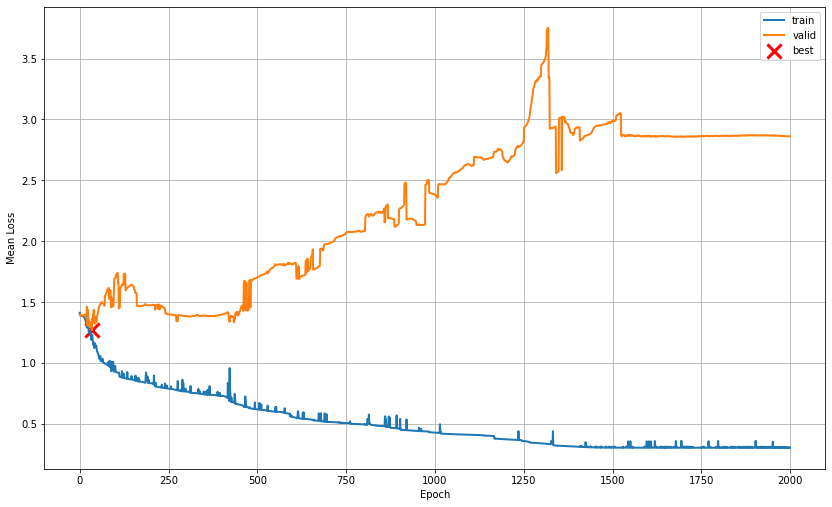

In [53]:
train_result.plot_losses()